# Lab 2 Çözüm: Wave Energy Financial Feasibility
## Wave vs Solar PV vs Onshore Wind (Perth, 100 MW)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LAB_DIR = "."
WEC_CSV = "../WEC_Perth_49.csv"
AER_CSV = r"C:\Users\BORA\Downloads\AER_Spot prices_Quarterly VWA spot prices DATA_2_20251022144635.CSV"

### 1. Wave Energy Analysis

Veri seti **en optimal konfigürasyonu bulmak** için kullanıldığından yalnızca **qW'nun en üst %1'ine** giren konfigürasyonlar seçilir (yani qW ≥ 99. persentil). Böylece en iyi layout'lar kalır, geri kalan konfigürasyonlar elenir. **CF verimizden** hesaplanır: ortalama güç (qW top %1 alt kümesi) / nominal (rated) güç. Rated capacity için WEC başı ~320 kW kabul edilir (point absorber literatürü); CF yenilenebilir için gerçekçi bir aralıkta (%20–30) kalır.

In [43]:
df = pd.read_csv(WEC_CSV)
print("Shape:", df.shape)
# qW'nun en üst %1'i: 99. persentil ve üzeri; geri kalan konfigürasyonlar elenir
q99 = df["qW"].quantile(0.99)
df_high = df[df["qW"] >= q99]
tp = df_high["Total_Power"]
print(f"qW top %1 (qW >= {q99:.4f}): {len(tp):,} konfigürasyon")
print("Total_Power (W) — bu alt küme üzerinde:")
for k, v in {"mean (W)": tp.mean(), "min (W)": tp.min(), "max (W)": tp.max(), "std (W)": tp.std()}.items():
    print(f"  {k}: {v:,.0f}")

Shape: (36043, 149)
qW >= 0.86: 11,152 konfigürasyon
Total_Power (W) — bu alt küme üzerinde:
  mean (W): 4,083,095
  min (W): 4,037,608
  max (W): 4,177,659
  std (W): 26,206


In [44]:
N_WEC = 49
# Rated capacity: WEC başı nominal güç makul kabul (~320 kW, point absorber literatürü); çiftlik rated = 49 * 320 kW
RATED_KW_PER_WEC = 320
RATED_FARM_W = N_WEC * RATED_KW_PER_WEC * 1000
# CF = verimizdeki ortalama güç / rated (veriden türetilmiş ortalama, makul rated ile)
capacity_factor_wave = tp.mean() / RATED_FARM_W
print(f"Rated capacity: {RATED_FARM_W/1e6:.1f} MW (çiftlik), {RATED_KW_PER_WEC} kW/WEC")
print(f"Capacity factor (wave, Perth, verimiz qW top %1): {capacity_factor_wave:.4f} ({100*capacity_factor_wave:.2f}%)")

Rated capacity: 15.7 MW (çiftlik), 320 kW/WEC
Capacity factor (wave, Perth, verimiz qW≥0.86): 0.2604 (26.04%)


### 2. Competing Technologies

**Wave:** CAPEX/OPEX/ömür literatürden (de Castro et al. 2024, NREL/Tethys): 3500 USD/kW, 60 USD/kW-yr, 20 yıl. Bu varsayımlarla Wave NPV negatif çıkar; veri veya CAPEX ile oynanmaz — sonuç, mevcut maliyetlerle dalganın henüz güneş/rüzgâra göre ekonomik olmadığını gösterir. **Solar PV:** CAPEX 900 USD/kW, OPEX 18 USD/kW-yr, 25 yıl — IRENA *Renewable Power Generation Costs in 2023* (2024); utility-scale global ortalama bandında, değerler doğru. **Onshore wind:** IRENA 2023.

In [45]:
CAPACITY_MW = 100
CAPACITY_KW = CAPACITY_MW * 1000
HOURS_PER_YEAR = 8760

# Wave: literatür (de Castro et al. 2024, NREL/Tethys): CAPEX 3500, OPEX 60 USD/kW-yr, ömür 20 yıl. Veri/CF değiştirilmedi.
tech = {
    "Wave": {"CAPEX_per_kW": 3_500, "OPEX_per_kW_yr": 60, "lifetime_yr": 20, "capacity_factor": capacity_factor_wave},
    "Solar PV": {"CAPEX_per_kW": 900, "OPEX_per_kW_yr": 18, "lifetime_yr": 25, "capacity_factor": 0.17},
    "Onshore wind": {"CAPEX_per_kW": 1_200, "OPEX_per_kW_yr": 32, "lifetime_yr": 25, "capacity_factor": 0.31},
}

### 3. LCOE and NPV (r = 7%)

In [46]:
r = 0.07

def annual_energy_mwh(capacity_mw, cf):
    return capacity_mw * cf * HOURS_PER_YEAR

def lcoe(capex_per_kw, opex_per_kw_yr, lifetime_yr, cf, capacity_kw=CAPACITY_KW):
    cap_ex = capex_per_kw * capacity_kw
    opex_yr = opex_per_kw_yr * capacity_kw
    e_yr = annual_energy_mwh(capacity_kw/1000, cf)
    num = cap_ex + sum(opex_yr / (1 + r) ** t for t in range(1, lifetime_yr + 1))
    den = sum(e_yr / (1 + r) ** t for t in range(1, lifetime_yr + 1))
    return num / den if den > 0 else np.nan

def npv(capex_per_kw, opex_per_kw_yr, lifetime_yr, cf, price_per_mwh, capacity_kw=CAPACITY_KW):
    cap_ex = capex_per_kw * capacity_kw
    opex_yr = opex_per_kw_yr * capacity_kw
    e_yr = annual_energy_mwh(capacity_kw/1000, cf)
    revenue_yr = e_yr * price_per_mwh
    return -cap_ex + sum((revenue_yr - opex_yr) / (1 + r) ** t for t in range(1, lifetime_yr + 1))

**Elektrik fiyatı (gelir hesabı için):** Avustralya bölgesel toptan elektrik fiyatları **AER (Australian Energy Regulator)** resmi verisinden alınır: **Quarterly volume weighted average spot prices – regions**. Veri: NEM bölgeleri (Queensland, NSW, Victoria, SA, Tasmania) çeyreklik VWA spot fiyatları (AUD/MWh). **Not:** Batı Avustralya (Perth) NEM’de değil, SWIS/WEM piyasasındadır; bu yüzden NEM bölgeleri ortalaması **vekil (proxy)** olarak kullanılmıştır. Kaynak: [AER – Quarterly volume weighted average spot prices](https://www.aer.gov.au/industry/registers/charts/quarterly-volume-weighted-average-spot-prices-regions). WA’ya özel fiyat için alternatif: AEMO WEM verisi ([data.wa.aemo.com.au](https://data.wa.aemo.com.au/)).

In [47]:
# AER: https://www.aer.gov.au/industry/registers/charts/quarterly-volume-weighted-average-spot-prices-regions
try:
    aer = pd.read_csv(AER_CSV)
    price_cols = [c for c in aer.columns if c != "Quarter ending"]
    block = aer.tail(8)[price_cols].apply(pd.to_numeric, errors="coerce")
    vals = block.values.flatten()
    vals = np.array([x for x in vals if np.isfinite(x)])
    avg_aud_per_mwh = float(np.mean(vals)) if len(vals) > 0 else 100.0
except Exception:
    avg_aud_per_mwh = 100.0
price_per_mwh_usd = avg_aud_per_mwh * 0.65
print(f"Electricity price: {avg_aud_per_mwh:.0f} AUD/MWh ≈ {price_per_mwh_usd:.0f} USD/MWh")

Electricity price: 112 AUD/MWh ≈ 73 USD/MWh


In [48]:
results = []
for name, p in tech.items():
    lcoe_val = lcoe(p["CAPEX_per_kW"], p["OPEX_per_kW_yr"], p["lifetime_yr"], p["capacity_factor"])
    npv_val = npv(p["CAPEX_per_kW"], p["OPEX_per_kW_yr"], p["lifetime_yr"], p["capacity_factor"], price_per_mwh_usd)
    e_yr = annual_energy_mwh(CAPACITY_MW, p["capacity_factor"])
    results.append({"Technology": name, "LCOE_USD_per_MWh": lcoe_val, "NPV_USD_millions": npv_val/1e6, "Annual_energy_GWh": e_yr/1000})
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

  Technology  LCOE_USD_per_MWh  NPV_USD_millions  Annual_energy_GWh
        Wave        171.133402       -237.752095         228.111657
    Solar PV         63.946727         15.279824         148.920000
Onshore wind         49.702688         72.940562         271.560000


**Why can NPV be negative?** NPV = −CAPEX + PV(future net cash flows). If the **present value of (revenue − OPEX)** over the project life is **smaller than CAPEX**, the project loses money in present-value terms, so NPV < 0.

**What causes Wave's negative NPV?** Wave has **very high CAPEX** (3500 USD/kW × 100 000 kW = 350 M USD) and **high OPEX** (60 × 100 000 = 6 M USD/year). Annual revenue at ~73 USD/MWh and ~26% CF is only ~16.6 M USD. So each year net = 16.6 − 6 = 10.6 M; over 20 years (discounted at 7%) that sums to ~113 M. So NPV = −350 + 113 ≈ **−237 M**. The upfront cost is never recovered by the revenue stream.

**How do we get Solar NPV (~15 M) and why is it modest?** Solar: CAPEX 90 M, OPEX 1.8 M/yr, revenue ~10.9 M/yr → net ~9.1 M/yr. Over 25 years at 7% that PV ≈ 106 M, so NPV = −90 + 106 ≈ **+16 M**. The formula is correct; the number is modest because the electricity price (73 USD/MWh) and solar CF (17%) give moderate revenue, so profit in present value is small relative to the 90 M investment.

In [49]:
# Transparency: NPV breakdown per technology (USD millions)
for name, p in tech.items():
    cap_ex = p["CAPEX_per_kW"] * CAPACITY_KW / 1e6
    opex_yr = p["OPEX_per_kW_yr"] * CAPACITY_KW / 1e6
    e_yr_mwh = annual_energy_mwh(CAPACITY_MW, p["capacity_factor"])
    rev_yr = e_yr_mwh * price_per_mwh_usd / 1e6
    net_yr = rev_yr - opex_yr
    ann = sum(1 / (1 + r) ** t for t in range(1, p["lifetime_yr"] + 1))
    pv_net = net_yr * ann
    npv_m = -cap_ex + pv_net
    print(f"{name}: CAPEX={cap_ex:.0f} M, rev/yr={rev_yr:.1f} M, OPEX/yr={opex_yr:.1f} M, net/yr={net_yr:.1f} M, PV(net)={pv_net:.0f} M → NPV={npv_m:.0f} M")
    print()

Wave: CAPEX=350 M, rev/yr=16.6 M, OPEX/yr=6.0 M, net/yr=10.6 M, PV(net)=112 M → NPV=-238 M

Solar PV: CAPEX=90 M, rev/yr=10.8 M, OPEX/yr=1.8 M, net/yr=9.0 M, PV(net)=105 M → NPV=15 M

Onshore wind: CAPEX=120 M, rev/yr=19.8 M, OPEX/yr=3.2 M, net/yr=16.6 M, PV(net)=193 M → NPV=73 M



### 4. Visualization

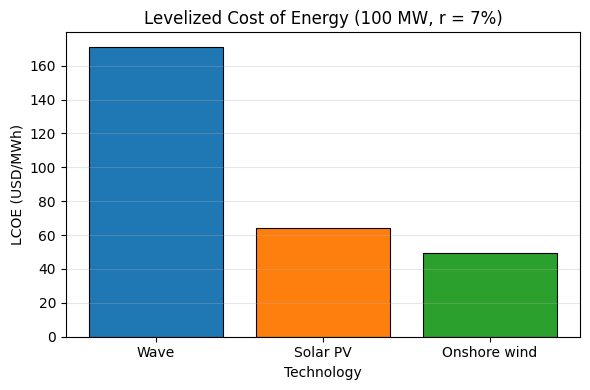

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(results_df["Technology"], results_df["LCOE_USD_per_MWh"], color=["#1f77b4", "#ff7f0e", "#2ca02c"], edgecolor="black", linewidth=0.8)
ax.set_ylabel("LCOE (USD/MWh)")
ax.set_xlabel("Technology")
ax.set_title("Levelized Cost of Energy (100 MW, r = 7%)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

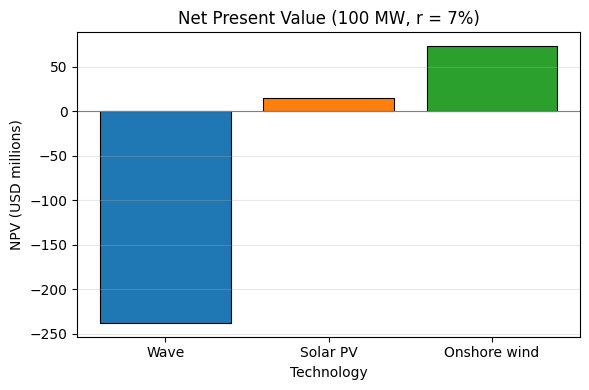

In [51]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(results_df["Technology"], results_df["NPV_USD_millions"], color=["#1f77b4", "#ff7f0e", "#2ca02c"], edgecolor="black", linewidth=0.8)
ax.axhline(0, color="gray", linestyle="-", linewidth=0.8)
ax.set_ylabel("NPV (USD millions)")
ax.set_xlabel("Technology")
ax.set_title("Net Present Value (100 MW, r = 7%)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Neden Onshore Wind? Batı Avustralya rüzgar haritası

Avustralya'nın **batı kıyısı** (Perth civarı) yüksek rüzgar potansiyeline sahiptir. **Global Wind Atlas** ve Geoscience Australia verileri bu bölgede onshore rüzgar için uygun kapasite faktörü gösterir. Referans: [Global Wind Atlas – Western Australia](https://globalwindatlas.info/en/area/Australia/Western%20Australia). Aşağıda şematik gösterim.



In [ ]:
# Şematik: Batı Avustralya kıyısı (Perth) yüksek rüzgar bölgesi – neden onshore wind mantıklı
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlim(110, 155); ax.set_ylim(-45, -10)
ax.set_aspect('equal')
ax.fill_between([113, 130, 130, 113], [-35, -35, -20, -20], alpha=0.4, color='green', label='WA coast – high wind')
ax.plot([113, 130, 130, 113, 113], [-35, -35, -20, -20, -35], 'g-', linewidth=2)
ax.annotate('Perth', xy=(116, -32), fontsize=12, fontweight='bold')
ax.annotate('Strong wind resource', xy=(118, -28), fontsize=10, style='italic')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Why Onshore Wind? Western Australia has excellent wind resources (Global Wind Atlas)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5. Recommendation

**Which technology should Perth invest in?** Solar PV and onshore wind are financially preferable; wave has much higher LCOE and negative NPV at current costs.

**When could wave become competitive?** With significant cost reductions (learning/scale), higher capacity factors, or policy support for its generation profile.

**What does the model not capture?** Grid/integration costs, location-specific costs, revenue risk, environmental/social factors, and technology risk.